In [5]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [6]:
ridership = pd.read_csv("../files/ridership_Daily_Boarding_Totals.csv", parse_dates=['service_date'])
ridership.columns = ['date', 'day_type', 'bus', 'rail', 'total']
ridership = ridership.sort_values(by='date').set_index("date")
ridership.drop(['total'], axis=1, inplace=True)
ridership.drop_duplicates()

ridership

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2021-11-26,W,257700,189694
2021-11-27,A,237839,187065
2021-11-28,U,184817,147830


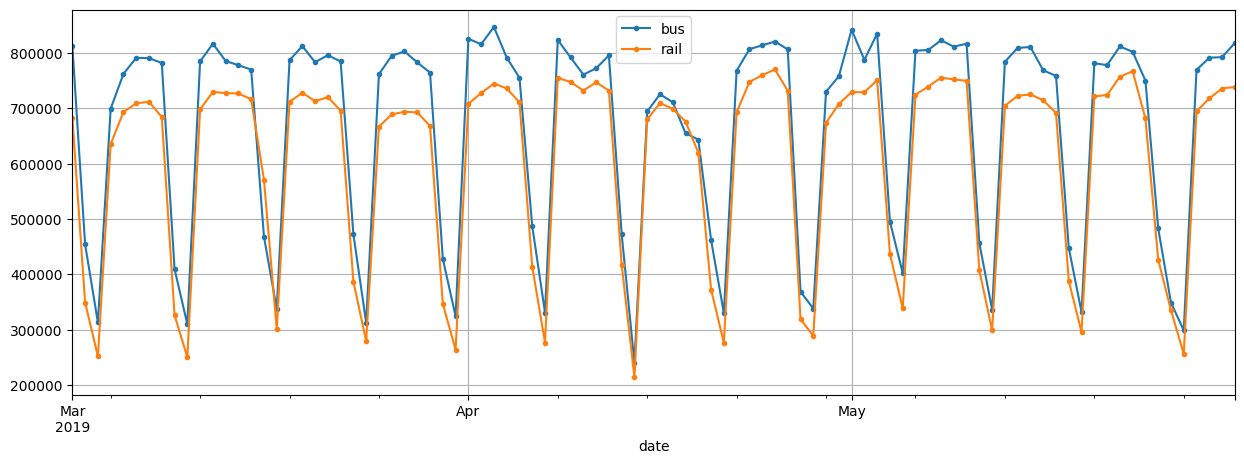

In [7]:
ridership["2019-03":"2019-05"].plot(grid=True, marker='.', figsize=(15, 5))
plt.show()

#### in this chart we can see that we have a strong weekly seasonality so we are going to do naive forecasting with a lag of 7 days instead of 1 day because it will be more accurate

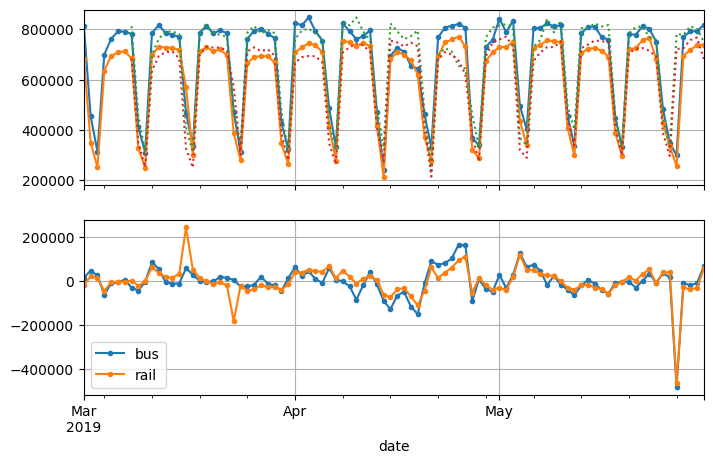

In [8]:
diff_7 = ridership[['bus', 'rail']].diff(7)['2019-03': '2019-05'] # diff(7) is the difference between the value at time t and the value at time t-7
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

ridership["2019-03":"2019-05"].plot(ax=ax[0], legend=False, marker='.', grid=True)
ridership["2019-03":"2019-05"].shift(7).plot(ax=ax[0], grid=True, legend=False, linestyle=':') # original data lagged by 7 days

diff_7.plot(ax=ax[1], marker='.', grid=True)

plt.show()

In [10]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

here we are computing the **mean absolute percentage error**, in this case we can see that the bus has a lower error than the rail,
with **mean_absolute_error** we can see it is the opposite, that is because the bus have higher values than the rail so the error is bigger
but when we put the error in perspective, bus is slightly better than rail

In [11]:
(diff_7 / ridership["2019-03":"2019-05"][['bus', 'rail']]).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

**MAE, MSE, MSE** are among the most common metrics, you can use for evaluate your forecasts. As always, depend on the task.
For example, if yor project suffer from quadratically more from large errors than from small ones, then the MSE is preferable, as it strongly penalizes large errors.


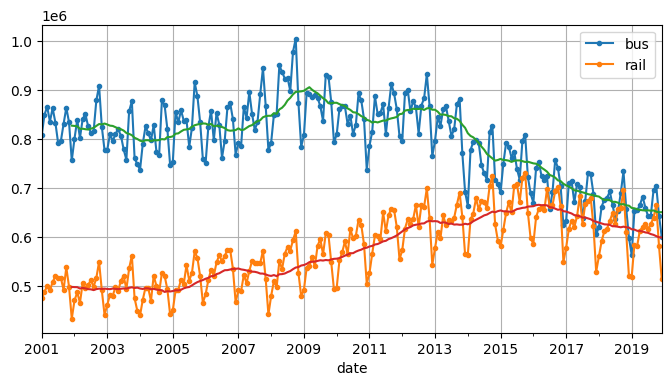

In [13]:
# now we are going to check if there's any year seasonality rolling the data with the mean of the last 12 months
period = slice("2001", "2019")
df_monthly = ridership[['bus', 'rail']].resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean() # this is the same as the window average in the previous notebook

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

### we can see that there's a yearly seasonality

#### to check if the data have a yearly seasonality we can do differencing, differencing is also used to remove trend and seasonality getting a stationary time series. The models like ARIMA and SARIMA are based on stationary time series. The idea is to remove trend and seasonality, then apply the model and finally add the trend and seasonality back to the predicted values. 

<Axes: xlabel='date'>

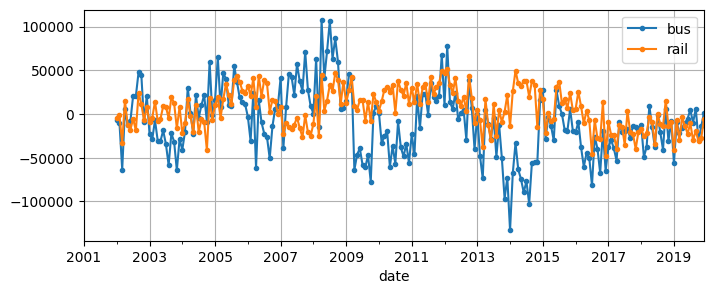

In [14]:
diff_12 = df_monthly.loc[period, ['bus', 'rail']].diff(12)
diff_12.plot(grid=True, marker='.', figsize=(8, 3))

<Axes: title={'center': 'Differenced Data'}, xlabel='date'>

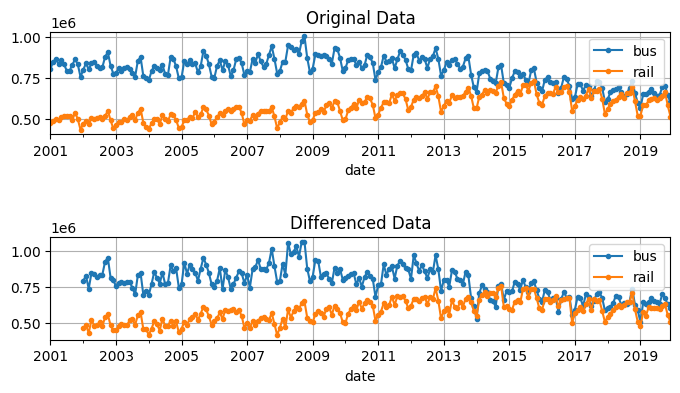

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(8, 4))
df_monthly_diff = df_monthly[period] + diff_12
plt.subplots_adjust(hspace=1)  # Adjust the vertical space

df_monthly[period].plot(ax=axs[0], marker='.', grid=True, title='Original Data')
df_monthly_diff.plot(ax=axs[1], marker='.', grid=True, title='Differenced Data')

#### we can see that that the data have a yearly seasonality because when we return the data to the original values the seasonality is still there